In [ ]:
#!python -m pip install --upgrade pip setuptools wheel --quiet

In [2]:
#!pip install -r requirements.txt --quiet

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import numpy as np
import pytensor.tensor as pt
import os
import arviz as az
import pickle
 
from IPython.display import Image, display
from graphviz import Digraph
import xarray as xr
az.style.use("arviz-darkgrid")

# Display settings
pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


# Load Data

In [5]:
df = pd.read_csv('./data/data.csv')

In [6]:
# Convert the 'wk_strt_dt' column to datetime format
df['wk_strt_dt'] = pd.to_datetime(df['wk_strt_dt'])

# Sort the DataFrame by week start date and reset the index
df = df.sort_values('wk_strt_dt').reset_index(drop=True)

# Calculate the difference in days between consecutive week start dates
date_diffs = df['wk_strt_dt'].diff().dt.days

# Identify rows (excluding the first) where the difference is not exactly 7 days
anomalies = df.loc[(date_diffs != 7) & (date_diffs.notna())]

# Display rows that break the expected weekly interval
print("Rows where the date gap is not 1 week:")
anomalies


Rows where the date gap is not 1 week:


,wk_strt_dt,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,mdip_audtr,mdip_vidtr,mdip_viddig,mdip_so,mdip_on,mdip_em,mdip_sms,mdip_aff,mdip_sem,mdsp_dm,mdsp_inst,mdsp_nsp,mdsp_auddig,mdsp_audtr,mdsp_vidtr,mdsp_viddig,mdsp_so,mdsp_on,mdsp_sem,sales,me_ics_all,me_gas_dpg,st_ct,mrkdn_valadd_edw,mrkdn_pdm,va_pub_0.15,va_pub_0.2,va_pub_0.25,va_pub_0.3,hldy_Black Friday,hldy_Christmas Day,hldy_Christmas Eve,hldy_Columbus Day,hldy_Cyber Monday,hldy_Day after Christmas,hldy_Easter,hldy_Father's Day,hldy_Green Monday,hldy_July 4th,hldy_Labor Day,hldy_MLK,hldy_Memorial Day,hldy_Mother's Day,hldy_NYE,hldy_New Year's Day,hldy_Pre Thanksgiving,hldy_Presidents Day,hldy_Prime Day,hldy_Thanksgiving,hldy_Valentine's Day,hldy_Veterans Day,seas_prd_1,seas_prd_2,seas_prd_3,seas_prd_4,seas_prd_5,seas_prd_6,seas_prd_7,seas_prd_8,seas_prd_9,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48


In [7]:
channel_map = {
    'mdsp_dm': 'Direct Mail',
    'mdsp_inst': 'Insert',
    'mdsp_nsp': 'Newspaper',
    'mdsp_auddig': 'Digital Audio',
    'mdsp_audtr': 'Radio',
    'mdsp_vidtr': 'TV',
    'mdsp_viddig': 'Digital Video',
    'mdsp_so': 'Social',
    'mdsp_on': 'Online Display',
    'mdsp_sem': 'SEM'
}

In [8]:
# Select columns related to media spend: prefixed with 'mdsp_'
media_spend_cols = [col for col in df.columns if col.startswith('mdsp_')]

# Select columns related to media impressions: prefixed with 'mdip_'
media_impression_cols = [col for col in df.columns if col.startswith('mdip_')]

# Select macroeconomic indicator columns: prefixed with 'me_'
macro_economic_cols = [col for col in df.columns if col.startswith('me_')]

# Store count column: number of active stores
store_count_cols = ['st_ct']

# Select markdown-related columns (e.g., discount): prefixed with 'mrkdn_'
markdown_cols = [col for col in df.columns if col.startswith('mrkdn_')]

# Select holiday indicator columns: prefixed with 'hldy_'
holiday_cols = [col for col in df.columns if col.startswith('hldy_')]

# Select seasonal indicator columns: prefixed with 'seas_'
seasonality_cols = [col for col in df.columns if col.startswith('seas_')]

control_vars = (
    macro_economic_cols +
    store_count_cols +
    markdown_cols +
    holiday_cols +
    seasonality_cols
)

sales_col = 'sales'

reamining_cols = [col for col in df.columns if col not in control_vars + media_spend_cols + media_impression_cols + [sales_col]]

# EDA

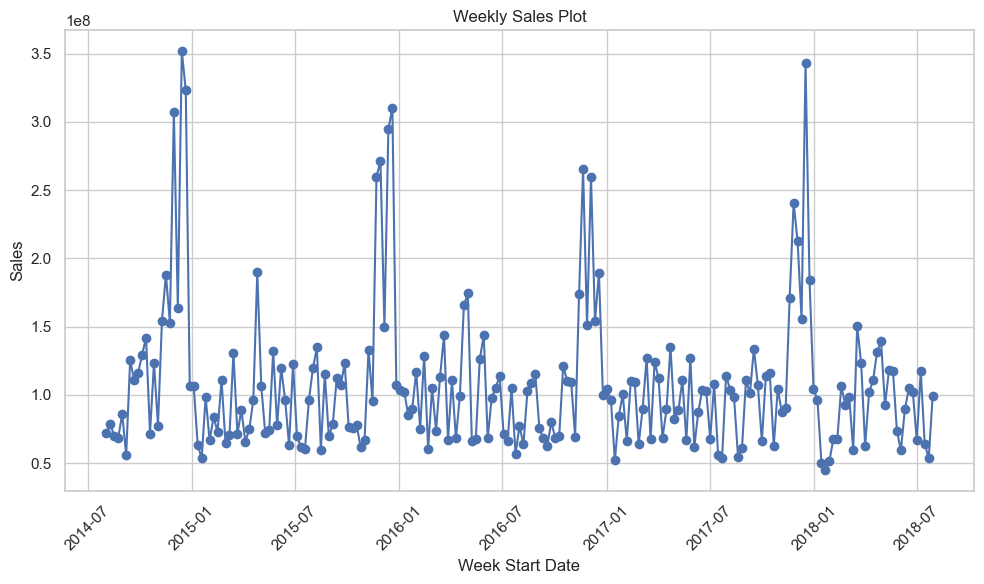

In [9]:
# Assuming 'df' is your DataFrame with columns 'wk_strt_dt' and 'sales'
# Make sure 'wk_strt_dt' is in datetime format
df['wk_strt_dt'] = pd.to_datetime(df['wk_strt_dt'])

# Plotting sales over time
plt.figure(figsize=(10,6))
plt.plot(df['wk_strt_dt'], df['sales'], marker='o', linestyle='-', color='b')

# Adding labels and title
plt.title('Weekly Sales Plot')
plt.xlabel('Week Start Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

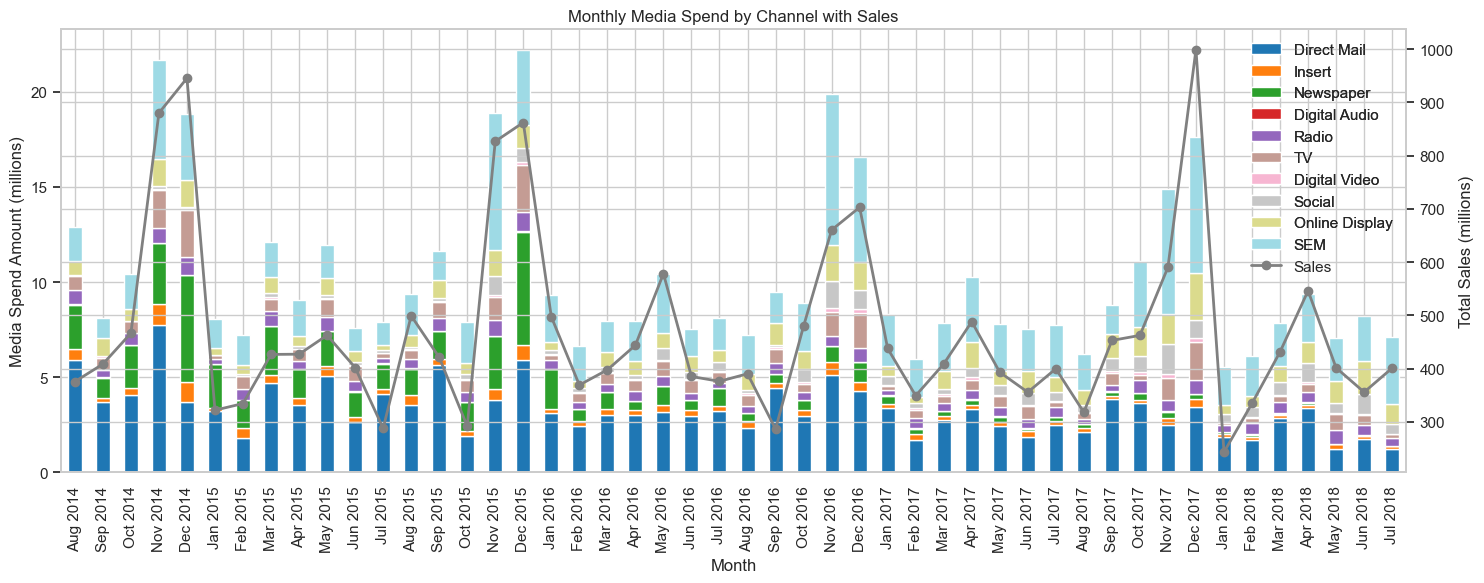

In [10]:
# Step 1: Create 'month' column from 'wk_strt_dt'
df['month'] = df['wk_strt_dt'].dt.to_period('M').dt.to_timestamp()

# Step 2: Group by month
monthly_spend = df.groupby('month')[media_spend_cols].sum()/1e6
monthly_sales = df.groupby('month')['sales'].sum()/1e6

# Step 3: Rename spend columns using channel_map
monthly_spend = monthly_spend.rename(columns=channel_map)

# Step 4: Create plot with secondary axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Bar plot for media spend
bars = monthly_spend.plot(kind='bar', stacked=True, ax=ax1, colormap='tab20')
ax1.set_ylabel('Media Spend Amount (millions)')
ax1.set_xlabel('Month')
ax1.set_title('Monthly Media Spend by Channel with Sales')
ax1.set_xticks(range(len(monthly_spend.index)))
ax1.set_xticklabels([d.strftime('%b %Y') for d in monthly_spend.index], rotation=90)

# Step 5: Overlay sales line on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(range(len(monthly_sales.index)), monthly_sales.values,
         color='grey', marker='o', linewidth=2, label='Sales')
ax2.set_ylabel('Total Sales (millions)')

# Step 6: Add legends
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax2.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()


# Normalize Data

In [11]:
# Determine the number of observations (rows in the dataset)
n_obs = df.shape[0]

# Count the number of media channels (e.g., TV, digital, radio)
n_media = len(media_spend_cols)

# Count the number of control variables (e.g., macroeconomic, holiday, markdown effects)
n_ctrl = len(control_vars)

# Extract the media spend data from the DataFrame
X_media_raw = df[media_spend_cols].values.astype(float)

# Extract media impression data from the DataFram
X_media_impression_raw = df[media_impression_cols].values.astype(float)

# Extract control variables data similarly
X_ctrl_raw = df[control_vars].values.astype(float)


In [12]:
def normalize_features(X, feature_names):
    """
    Normalize a feature matrix X based on simple rules:
    - Leave categorical/binary variables untouched.
    - Normalize continuous variables by dividing by the median (unless median is very small).

    Parameters:
        X (np.ndarray): Feature matrix of shape (n_samples, n_features)
        feature_names (list of str): List of column names corresponding to features in X

    Returns:
        X_normalized (np.ndarray): Normalized feature matrix
        transform_info (dict): Metadata describing how each feature was transformed
    """
    # Initialize an array of zeros with the same shape as X to store normalized values
    X_normalized = np.zeros_like(X)

    # Dictionary to store how each column was transformed
    transform_info = {}

    # Loop through each feature by index and name
    for i, col in enumerate(feature_names):
        col_values = X[:, i]
        unique_vals = np.unique(col_values)

        if len(unique_vals) <= 3:
            # Likely a binary or categorical variable: no transformation
            #print(f"Column '{col}' has only {len(unique_vals)} unique values: {unique_vals}")
            X_normalized[:, i] = col_values
            transform_info[col] = {"type": "categorical"}

        else:
            # Continuous variable: normalize by dividing by its median
            #print(f"Column '{col}' has negative/positive values")
            median = np.nanmedian(col_values)
            print(f"Median: {median}")

            # Avoid division by very small medians that might distort scale
            if abs(median) < 5:
                median = 1

            # Normalize column
            X_normalized[:, i] = col_values / median
            transform_info[col] = {"type": "median", "median": median}

    return X_normalized, transform_info

In [13]:
# Normalize the media spend features using the defined normalization function
X_media_normalized, transform_info_media = normalize_features(X_media_raw, media_spend_cols)

# Normalize the media impression features using the defined normalization function
X_media_impression_normalized, transform_info_media_impression = normalize_features(X_media_impression_raw, media_spend_cols)

# Normalize the control variables in the same way
X_ctrl_normalized, transform_info_ctrl = normalize_features(X_ctrl_raw, control_vars)

Median: 670909.25
Median: 61208.05
Median: 128694.67
Median: 3237.4
Median: 116023.47
Median: 112353.17
Median: 12991.09
Median: 70799.44
Median: 186763.14
Median: 485503.95
Median: 7664954.0
Median: 8911466.0
Median: 887072.0
Median: 806117.0
Median: 19101601.0
Median: 7562079.0
Median: 835748.0
Median: 13810694.0
Median: 4100627.0
Median: 3452070.0
Median: 94.70000000000002
Median: 2.497
Median: 666.0
Median: 0.3606945308571429
Median: 0.3384641758571429


In [14]:
df_media_norm = pd.DataFrame(X_media_normalized, columns=[f"{col}_norm" for col in media_spend_cols])
df_media_impression_norm = pd.DataFrame(X_media_impression_normalized, columns=[f"{col}_norm" for col in media_impression_cols])
df_ctrl_norm = pd.DataFrame(X_ctrl_normalized, columns=[f"{col}_norm" for col in control_vars])

df_media_norm.index = df.index
df_media_impression_norm.index = df.index
df_ctrl_norm.index = df.index

df = pd.concat([df, df_media_norm,df_media_impression_norm, df_ctrl_norm], axis=1)


# Function to build lagged marketing spend features and model diminishing returns

In [15]:
# ---------- Lagging Function ----------
def make_lagged_X_media(X_media, max_lag):
    """
    Creates lagged versions of media spend inputs for time-dependent modeling (e.g., adstock models).

    Parameters:
        X_media (ndarray): Normalized media spend data of shape (n_obs, n_media)
        max_lag (int): Total number of lags to generate, including current time step (t=0)

    Returns:
        X_media_t_0 (ndarray): Media spend at time t (no lag), shape (n_obs, n_media)
        lagged (ndarray): Lagged media from t-1 to t-(max_lag-1),
                          shape (n_obs, max_lag - 1, n_media)
                          Lag values for early rows (where lag exceeds available data) will be zeros.
    """
    n_obs, n_media = X_media.shape

    # Initialize a 3D array to store lagged media data
    # Shape: (observations, lags, media channels)
    lagged = np.zeros((n_obs, max_lag - 1, n_media))  # t-1 to t-(max_lag-1)

    # Populate lagged values — each lag gets its own "slice" along axis 1
    for lag in range(1, max_lag):
        lagged[lag:, lag - 1, :] = X_media[:-lag]  # shift the media back by 'lag' steps

    return X_media.copy(), lagged  # Return current period media and its lags

# ---------- Hill Transformation ----------
def hill_transform(x, ec, slope, epsilon=1e-6):
    """
    Hill function transformation — models diminishing returns (saturation) in media response.

    Parameters:
        x (Tensor): Media input (can be scalar, vector, or tensor)
        ec (float or Tensor): Half-saturation point (effective concentration)
        slope (float or Tensor): Controls steepness of curve (higher = sharper saturation)
        epsilon (float): Small value added for numerical stability (avoids divide-by-zero)

    Returns:
        Tensor: Transformed values, same shape as x
    """
    return 1 / (1 + pt.pow((x + epsilon) / (ec + epsilon), -slope))


In [16]:
# --------- Lagged Media Spending ----------
max_lag = 7  # Maximum number of lags to consider (e.g., last 7 weeks of media effects)

# Create current-period and lagged media features from normalized media spend
X_media_t_0, lagged_media = make_lagged_X_media(X_media_normalized, max_lag=max_lag)

# Remove the first 'max_lag' rows to account for lagged data alignment
X_media_t_0 = X_media_t_0[max_lag:]
lagged_media = lagged_media[max_lag:]
X_ctrl = X_ctrl_normalized[max_lag:]

# Prepare the target variable (sales), convert to float, and align with lagged features
df['sales_normalized'] = df[sales_col].values.astype(float)

# Normalize the target variable by dividing by its median
df['sales_normalized'] = df['sales_normalized']/np.median(df[sales_col])  #median

# Take the log of normalized sales for modeling (e.g., regression assumes log-normality)
df['log_sales_normalized'] = np.log(df['sales_normalized'])


log_Y = df.loc[max_lag:, 'log_sales_normalized'].values.astype(float)

n_obs = log_Y.shape[0]
n_media = len(media_spend_cols)
n_ctrl = len(control_vars)

# Visualize Target Distribution

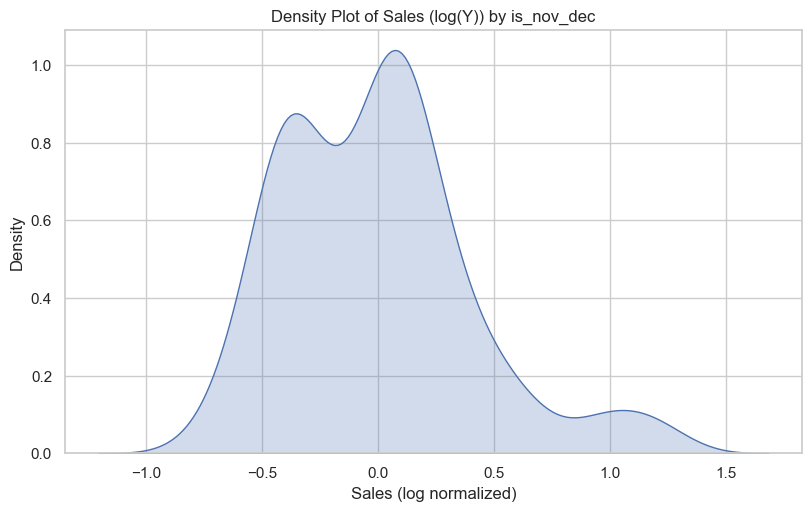

In [17]:

# Plot the log-transformed sales distribution by is_nov_dec
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='log_sales_normalized', fill=True, common_norm=False, palette='Set2')
plt.title("Density Plot of Sales (log(Y)) by is_nov_dec")
plt.xlabel("Sales (log normalized)")
plt.ylabel("Density")
plt.grid(True)
plt.show()


# Bayesian model


### **Model Equation** (Simplified form):

* **Baseline sales** (intercept)
* **Media spend** (current and past, adjusted by adstock transformation and diminishing returns)
* **Control variables** (such as macroeconomic factors or store counts)

$$
\log(\text{Sales}_t) = \text{Baseline} + \sum_{i=1}^{n_{\text{media}}} \left( \text{Hill Transformed Spend}_i + \text{Lagged Media}_i \right) \cdot \beta_i + \sum_{j=1}^{n_{\text{ctrl}}} \left( \text{Control Variable}_j \right) \cdot \alpha_j + \epsilon
$$

Where:

* $\text{Hill Transformed Spend}_i$ models diminishing returns for media spend.
* $\text{Lagged Media}_i$ accounts for delayed effects.
* $\epsilon$ is the error term, representing noise in the data.


In [18]:
# Coordinates for different dimensions: media types, time periods, and control variables
media_types = media_spend_cols        #(shape: n_media)
time_periods = np.arange(0, max_lag-1)  #(shape: max_lag)
control_vars = control_vars           # (shape: n_ctrl)

# --------- Model -----------

with pm.Model(coords={"media": media_types, "time": time_periods, "control": control_vars,"obs_ind":np.arange(len(log_Y))}) as media_mix_model_with_adstock:

    # --------- Data -----------
    # Data for the current period media spend (n_obs, n_media)
    media_now = pm.Data("Media Spend at time t", X_media_t_0, dims=("obs_ind","media"))

    # Data for media spend lags (n_obs, max_lag-1, n_media)
    media_lags = pm.Data(f"Media Spend in previous weeks (t-1 to t-{max_lag-1})", lagged_media, dims=("obs_ind","time","media"))

    ### Data for output
    output = pm.Data("y", log_Y, dims="obs_ind")

    # --------- Random Variable -----------
    # Baseline intercept for the model (average sales level)
    baseline_intercept = pm.Normal("Baseline Sales", mu=np.mean(log_Y), sigma=5)

    # Hill function parameter: Effective Concentration to model diminishing returns
    ec = 0.01 + 0.99 * pm.Beta("ec", alpha=2, beta=2, shape=len(media_types), dims="media")
    # Hill function parameter: Slope for the Hill function, controlling steepness of the response curve
    slope = pm.HalfNormal("slope", sigma=1, shape=len(media_types), dims="media")

    # Adstock parameter: Retention Rate
    retention_rate = pm.Beta("Retention Rate", alpha=3, beta=3, shape=len(media_types), dims="media")
    # Adstock parameter: Delay Parameter
    delay = pm.Uniform("Delay", lower=0, upper=max_lag - 2, shape=len(media_types), dims="media")

    # Coefficients for control variables
    control_coefficients = pm.Normal("Control Coefficients", mu=0, sigma=1, shape=len(control_vars), dims="control")

    # Media spend coefficients (scaled by global media scale)
    global_scale = pm.HalfNormal("global_media_scale", sigma=1)
    media_coefficients = pm.HalfNormal("Media Spend Coefficients", sigma=global_scale, shape=len(media_types), dims="media")

    # Noise variance to capture uncertainty in the model
    noise_variance = pm.HalfNormal("Noise Variance", sigma=1)

    # --------- Lag Weights Calculation (Adstock) -----------
    # Create lag weights for each time step (lag), based on retention rate and delay
    lag_ids = pt.arange(max_lag - 1)
    lag_weights = pt.pow(retention_rate.dimshuffle(0, 'x'), pt.sqr(lag_ids - delay.dimshuffle(0, 'x')))

    # Normalize the lag weights (ensuring they sum to 1 across lags)
    lag_weights = lag_weights / (pt.sum(lag_weights, axis=1, keepdims=True) + 1e-6)

    # --------- Adstocked Media Spend -----------
    # Reshape the media lags for matrix multiplication and apply lag weights
    media_lags_T = media_lags.dimshuffle(2, 0, 1)  # (n_media, n_obs, max_lag-1)

    # Calculate adstocked spend (past media spend weighted by retention and delay)
    weighted_adstocked_T = pm.Deterministic("Adstocked Spend (Delayed Effect)",
                                            (pt.sum(media_lags_T * lag_weights[:, None, :], axis=2)).T, dims=("obs_ind","media"))  # (n_media, n_obs)

    # Apply Hill transformation to the combined current and adstocked media spend
    hill_transformed_media = pm.Deterministic("Hill Transformed Spend (Diminishing Return)",
                                              hill_transform(media_now + weighted_adstocked_T, ec, slope), dims=("obs_ind","media"))

    # --------- Control and Media Contributions -----------
    # Media contribution to sales (weighted by media coefficients)
    media_contribution = pm.Deterministic("Media Contribution", pt.dot(hill_transformed_media, media_coefficients), dims="obs_ind")

    # Control variables contribution to sales (weighted by control coefficients)
    control_contribution = pm.Deterministic("Control Contribution", pt.dot(X_ctrl, control_coefficients), dims="obs_ind")

    # --------- Mean Prediction -----------
    mean_prediction = pm.Deterministic("Mean Prediction", baseline_intercept + media_contribution + control_contribution, dims="obs_ind")

    # --------- Likelihood (Observed Sales) -----------
    observed_sales = pm.Normal("Observed", mu=mean_prediction, sigma=noise_variance, observed=output, dims="obs_ind")


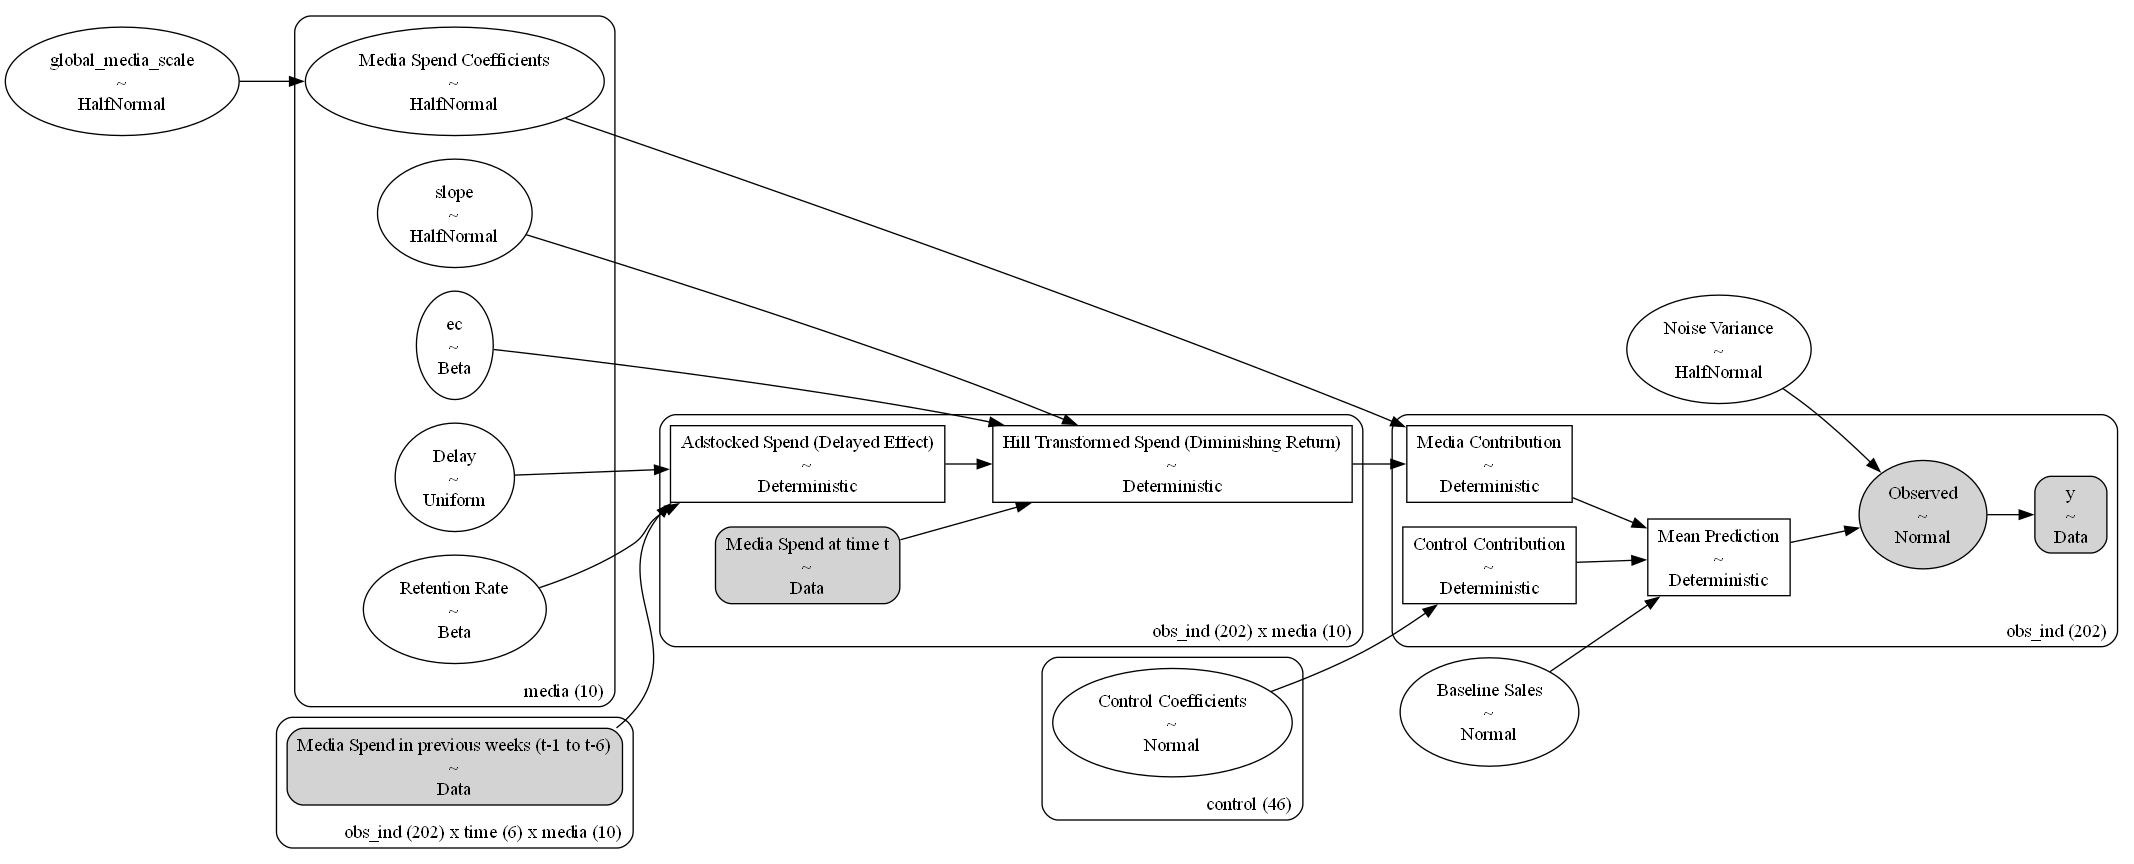

In [19]:
# Create graph from model
graph = pm.model_to_graphviz(media_mix_model_with_adstock)
graph.attr(rankdir="LR")  # Left to right layout
graph.format = "png"

# Render and show
graph.render('media_mix_model_graph', cleanup=True)
display(Image(filename='media_mix_model_graph.png'))


In [ ]:
# Flag to determine whether to rerun the sampling or load the existing trace
rerun = False

# Define the filename for storing the trace
trace_file = "media_mix_trace.pkl"

# Check if the trace file exists and we are not rerunning the sampling
if os.path.exists(trace_file) and not rerun:
    print("Loading existing trace...")
    # If trace file exists, load the saved trace object
    with open(trace_file, "rb") as f:
        trace = pickle.load(f)
else:
    print("Sampling model...")
    # If no existing trace or rerun is True, perform the sampling process
    with media_mix_model_with_adstock:
        # Run the sampling process with specified parameters
        trace = pm.sample(
            draws=3000,           # Number of posterior samples to draw
            tune=1000,            # Number of tuning steps (warmup)
            target_accept=0.975,    # Target acceptance rate for the sampler
            return_inferencedata=True,  # Return the trace as an InferenceData object (for easier analysis)
            cores=4,             # Use 4 cores for parallel sampling
            chains=4             # Run 4 chains in parallel
        )
    # Save the generated trace to a file for future use (so we don't have to sample again)
    with open(trace_file, "wb") as f:
        pickle.dump(trace, f)


Sampling model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Baseline Sales, ec, slope, Retention Rate, Delay, Control Coefficients, global_media_scale, Media Spend Coefficients, Noise Variance]


Output()

# Check MCMC Convergence

### Any divergences

In [21]:
n_divergences = trace.sample_stats["diverging"].sum().item()
print(f"Total divergences: {n_divergences}")

Total divergences: 0


### Any parameter with high R-hat or low effective sample size

In [22]:
# Summarize trace
summary = az.summary(trace, round_to=2)

In [23]:
# Define ESS threshold
ess_threshold = 500

# Filter for problematic parameters
problematic_params = summary[
    (summary['r_hat'] > 1.02) |
    (summary['ess_bulk'] < ess_threshold) |
    (summary['ess_tail'] < ess_threshold)
]

print("Parameters with potential convergence or sampling issues:\n")
print(problematic_params[['r_hat', 'ess_bulk', 'ess_tail']])

Parameters with potential convergence or sampling issues:

Empty DataFrame
Columns: [r_hat, ess_bulk, ess_tail]
Index: []


### Check Energy Diagnostic

<Axes: >

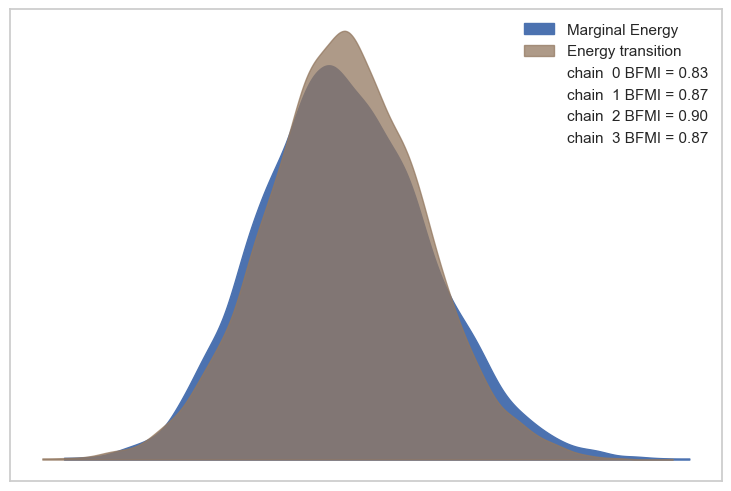

In [24]:
az.plot_energy(trace)

## Trace Plot

array([[<Axes: title={'center': 'Retention Rate'}>,
        <Axes: title={'center': 'Retention Rate'}>],
       [<Axes: title={'center': 'Delay'}>,
        <Axes: title={'center': 'Delay'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'ec'}>, <Axes: title={'center': 'ec'}>]],
      dtype=object)

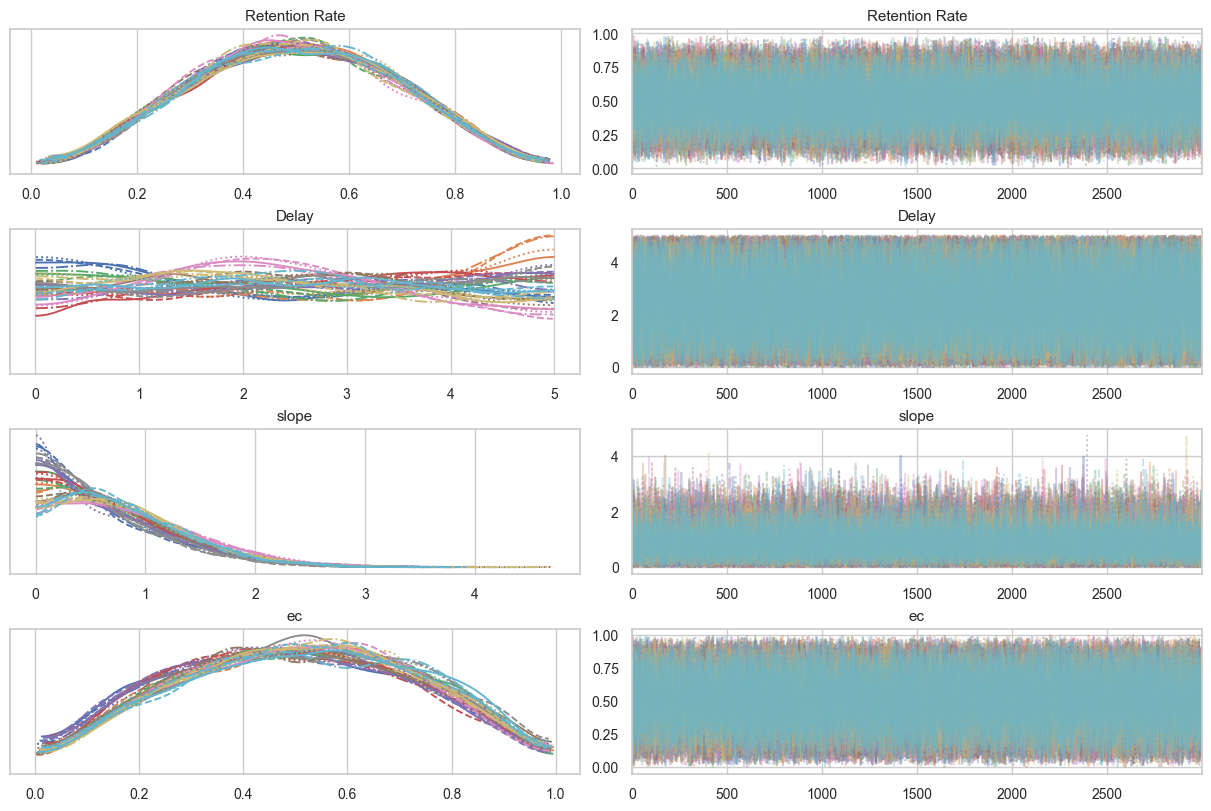

In [25]:
az.plot_trace(trace, var_names=["Retention Rate", "Delay", "slope", "ec"])

# Evaluate Posterior Predictive Accuracy


In [26]:
# Extract posterior samples for Mean Prediction
posterior_da = xr.DataArray(
    trace.posterior["Mean Prediction"].values,  # shape: (chains, draws, obs)
    dims=["chain", "draw", "obs_ind"]
)

posterior_mean = posterior_da.mean(dim=["chain", "draw"]).values
hpd_interval = az.hdi(posterior_da, hdi_prob=0.94).to_array().squeeze().values

posterior_mean.shape
hpd_interval.shape

(202, 2)

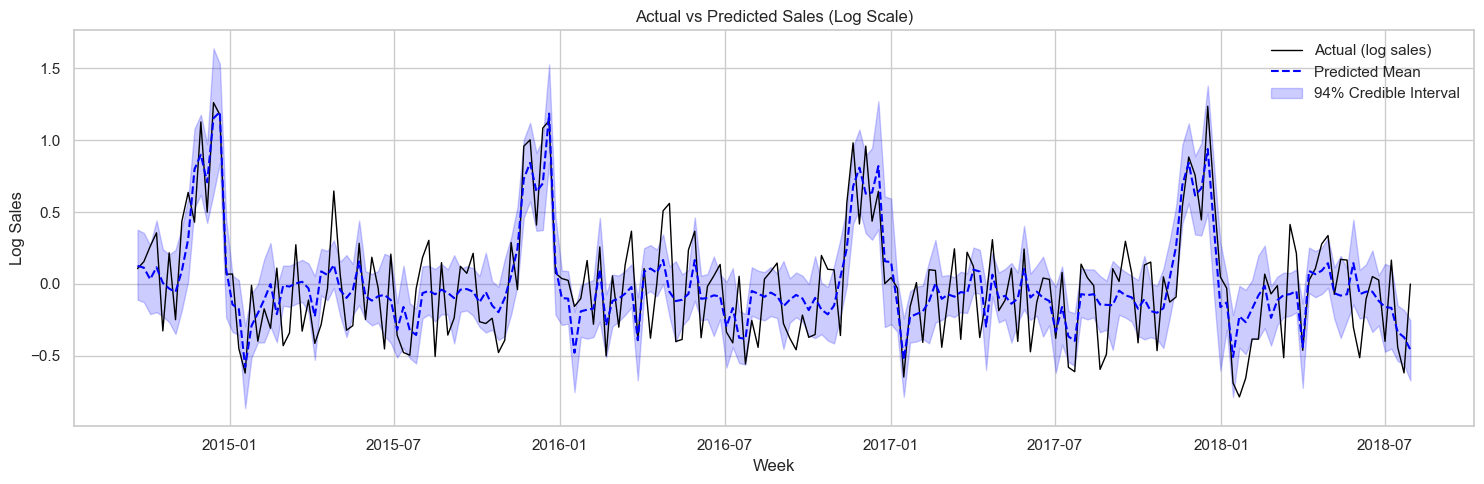

In [27]:
plot_df = pd.DataFrame({
    "week": df.loc[max_lag:,'wk_strt_dt'],
    "actual": log_Y,
    "predicted": posterior_mean,
    "hdi_lower": hpd_interval[:,0],
    "hdi_upper": hpd_interval[:,1],
})

plt.figure(figsize=(15, 5))

# Plot actual values
plt.plot(plot_df["week"], plot_df["actual"], label="Actual (log sales)", color="black", linewidth=1)

# Plot predicted mean
plt.plot(plot_df["week"], plot_df["predicted"], label="Predicted Mean", color="blue", linestyle="--")

# Fill between the 94% HDI
plt.fill_between(plot_df["week"], plot_df["hdi_lower"], plot_df["hdi_upper"],
                 color="blue", alpha=0.2, label="94% Credible Interval")

plt.xlabel("Week")
plt.ylabel("Log Sales")
plt.title("Actual vs Predicted Sales (Log Scale)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


# Learned Lag Weights


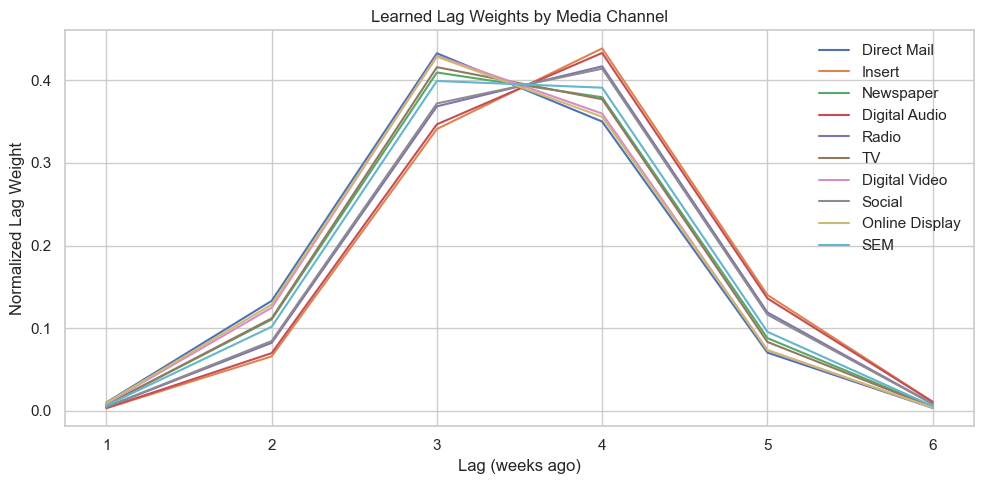

In [28]:
# Extract posterior samples
posterior = trace.posterior
retention = posterior["Retention Rate"].mean(dim=["chain", "draw"]).values
delay = posterior["Delay"].mean(dim=["chain", "draw"]).values
lag_ids = np.arange(max_lag - 1)

# Calculate mean lag weights
lag_weights_mean = np.array([
    (ret ** ((lag_ids - d) ** 2)) for ret, d in zip(retention, delay)
])

lag_weights_norm = lag_weights_mean / (lag_weights_mean.sum(axis=1, keepdims=True) + 1e-6)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(lag_weights_norm.shape[0]):
    media_key = list(channel_map.keys())[i]
    media_label = channel_map[media_key]
    ax.plot(lag_ids + 1, lag_weights_norm[i], label=media_label)


ax.set_title("Learned Lag Weights by Media Channel")
ax.set_xlabel("Lag (weeks ago)")
ax.set_ylabel("Normalized Lag Weight")
ax.legend()
plt.tight_layout()
plt.show()


## Hill Curves for Each Media Channel


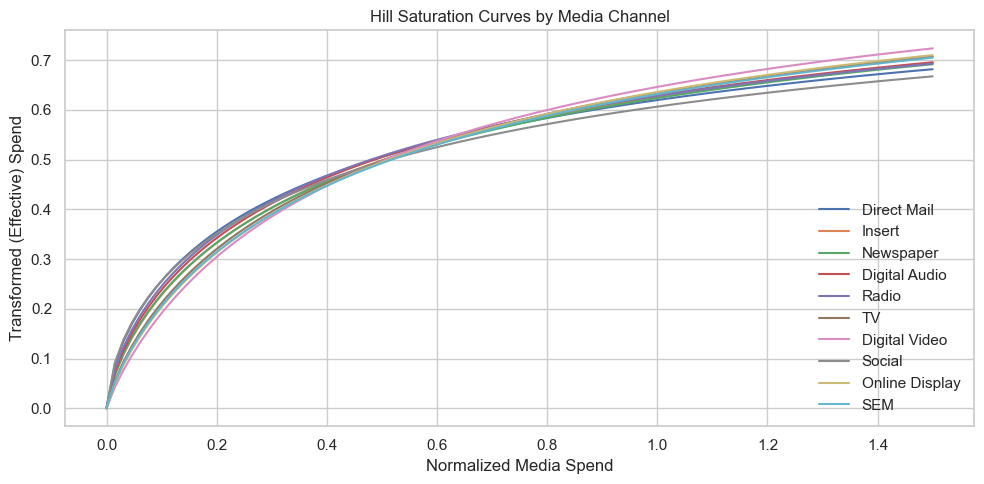

In [29]:
# Get posterior mean values
mean_ec = trace.posterior['ec'].mean(dim=["chain", "draw"]).values
mean_slope = trace.posterior['slope'].mean(dim=["chain", "draw"]).values

x_vals = np.linspace(0, 1.5, 100)  # Assume input is normalized media spend

fig, ax = plt.subplots(figsize=(10, 5))
for i in range(n_media):
    hill_vals = 1 / (1 + ((x_vals + 1e-6) / (mean_ec[i] + 1e-6)) ** (-mean_slope[i]))
    media_col = media_spend_cols[i]                # e.g., 'mdsp_tv'
    media_label = channel_map.get(media_col, media_col)  # e.g., 'TV'

    ax.plot(x_vals, hill_vals, label=f"{media_label}")

ax.set_title("Hill Saturation Curves by Media Channel")
ax.set_xlabel("Normalized Media Spend")
ax.set_ylabel("Transformed (Effective) Spend")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Media Contribution

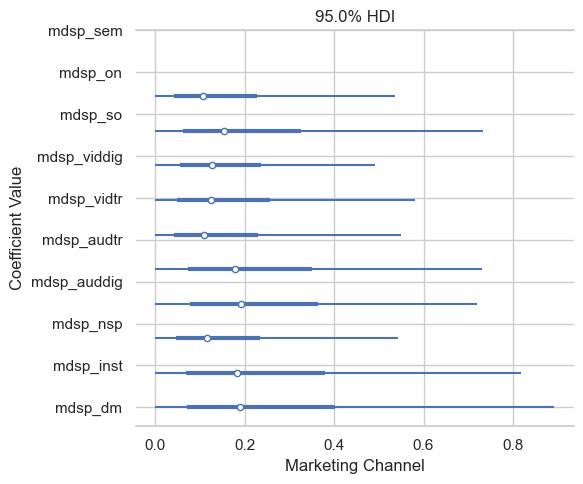

In [30]:
az.plot_forest(trace, var_names=["Media Spend Coefficients"], combined=True, hdi_prob=0.95);
plt.yticks(ticks=range(len(media_spend_cols)), labels=media_spend_cols, rotation=0)
plt.xlabel("Marketing Channel")
plt.ylabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()